# Convolutional Neural Networks & Computer Vision

Computer vision offers a way to take real world images, and computationally analyze to predict and find patterns within visual data. For instance, the camera of a Self-Driving car.

Why can't this be done using normal Feed-Forward Neural Networks? Simple, the first step in analyzing an image with Feed Forward Neural Nets, you need to flatten the image to a single vector. For instance, a 28 x 28 pixel image flattens to a vector of length, 784. This is an extremely small image, and the inputs is of length 784. This is problematic with larger images because for the deep neural network to analyze, because there will be an extremely high number of weights to populate, and makes identifying patterns an extremly complex task.


## Imports

In [1]:
import os
import pathlib
import random
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from src import utils

## Helpers

In [2]:
def summarize_image_directory(data_directory: pathlib.Path):
    # Lets look at the number of files in the test and train sets
    # TODO: Move this to a nice function
    for dirpath, dirnames, filenames in os.walk(data_directory):
        images = [file for file in filenames if file.endswith('jpg') or file.endswith('jpeg') or file.endswith('png')]
        if images:
            print(f'Directory: {dirpath} Total Images: {len(images)}')

In [3]:
def get_classnames_from_directory(data_directory: pathlib.Path):
    all_class_names = [
        item.name for item in data_directory.iterdir() if item.is_dir() and not item.name.startswith('.')
    ]
    class_names = np.array(sorted(all_class_names))
    return class_names

In [4]:
def view_random_image(target_dir: str, target_class: str):
    target_folder = f'{target_dir}/{target_class}'

    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + '/' + random_image[0])

    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    
    print(f'{target_class.capitalize()} - Image Shape: {img.shape}')
    return img

In [5]:
def view_image_from_batch(images, labels, index = None):
    if index is None:
        index = random.randint(0,len(images)-1)
    plt.figure()
    plt.imshow(images[index])
    plt.title(labels[index])
    plt.axis('off')

In [6]:
def load_and_prep_image(filename, img_shape=224):
    """ Reads and preprocesses a custom image."""
    img = tf.io.read_file(filename)
    
    # Decode file into a tensor
    img = tf.image.decode_image(img)
    
    # Resize image
    img = tf.image.resize(img, size=(img_shape, img_shape))
    
    # Normalize the image
    img = img / 255.
    
    return img

In [72]:
def get_predicted_class(model, filename, class_names):
    # Loading and prepping the image
    prepped_img = load_and_prep_image(filename)
    
    # Predicting the image
    prediction = model.predict(tf.expand_dims(prepped_img, axis=0))
    
    # Need to check for binary vs multiclass
    if len(prediction[0]) > 1:
        class_name = class_names[tf.argmax(prediction[0])]
    else:
        class_name_index = int(tf.round(prediction))
        class_name = class_names[class_name_index]
    
    # Plotting the image
    plt.figure()
    plt.imshow(prepped_img)
    plt.title(f'Image: {class_name.capitalize()} ({str(prediction[0][0]*100)[:4]}% Confident)')
    plt.axis(False)

## Download & Analyze Dataset

The dataset used is the Food 101 dataset commonly used to to explore Computer Vision. For simplicity of getting started with Computer Vision, I am only going to be looking at two image classes to work quickly with a smaller dataset before applying learnings to the larger dataset.

* https://www.kaggle.com/datasets/dansbecker/food-101 (original kaggle page of dataset)
* https://github.com/mrdbourke/tensorflow-deep-learning/ (getting the modified dataset)

In [8]:
# Image dataset location
data_directory = pathlib.Path('./data/food-101/pizza_steak')
test_directory = data_directory / 'test'
train_directory = data_directory / 'train'

In [9]:
# Lets look at the number of files in the test and train sets
# TODO: Move this to a nice function
for dirpath, dirnames, filenames in os.walk(str(data_directory)):
    images = [file for file in filenames if file.endswith('jpg') or file.endswith('jpeg') or file.endswith('png')]
    if images:
        print(f'Directory: {dirpath} Total Images: {len(images)}')


Directory: data/food-101/pizza_steak/test/steak Total Images: 250
Directory: data/food-101/pizza_steak/test/pizza Total Images: 250
Directory: data/food-101/pizza_steak/train/steak Total Images: 750
Directory: data/food-101/pizza_steak/train/pizza Total Images: 750


In [10]:
# Getting Class names programatically
class_names = np.array(sorted([item.name for item in train_directory.iterdir() if item.is_dir() and not item.name.startswith('.')]))
class_names

array(['pizza', 'steak'], dtype='<U5')

Pizza - Image Shape: (384, 512, 3)


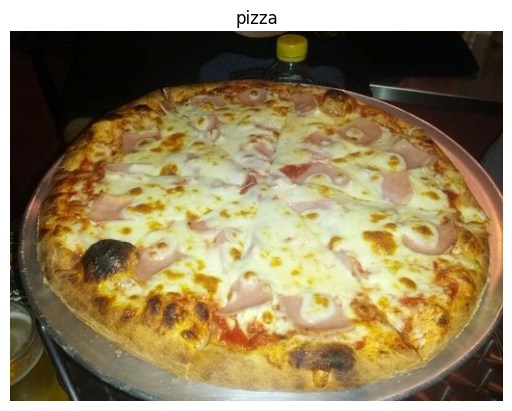

In [11]:
# View a random img from training dataset
pizza_img = view_random_image(target_dir=str(train_directory), target_class=class_names[0])

Steak - Image Shape: (512, 512, 3)


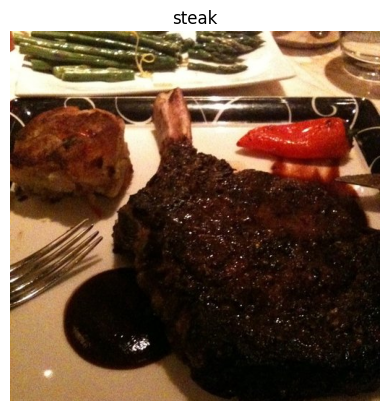

In [12]:
steak_img = view_random_image(target_dir=str(train_directory), target_class=class_names[1])

## End-to-End Example

1. Need to load our images.
2. Need to normalize the images
3. Need to build. a CNN to find patterns in our images.
4. Need to compile our CNN.
5. Fit the CNN to training data.

### Convolutional Neural Network Model

In [13]:
# Setting the random seed
tf.random.set_seed(42)

# 1. Preprocessing the data (Normalize all pixel values)
train_data_gen = ImageDataGenerator(rescale=1./255)
valid_data_gen = ImageDataGenerator(rescale=1./255)

# 2. Import data from directories and turn it into batches
train_data = train_data_gen.flow_from_directory(
    directory=str(train_directory),
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary',
    seed=42)

valid_data = valid_data_gen.flow_from_directory(
    directory=str(test_directory),
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary',
    seed=42)

# 3. Build the CNN Model
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding='valid'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# 4. Compile CNN Model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics='accuracy')

# 5. Fit the CNN Model
history_1 = model_1.fit(train_data, epochs=5, steps_per_epoch=len(train_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


2023-07-21 14:28:09.786628: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-07-21 14:28:09.786660: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-07-21 14:28:09.786663: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-07-21 14:28:09.787160: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-21 14:28:09.787350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/5


2023-07-21 14:28:10.293106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 4s 71ms/step - loss: 0.5708 - accuracy: 0.7120
Epoch 2/5
47/47 [==============================] - 3s 60ms/step - loss: 0.4584 - accuracy: 0.7960
Epoch 3/5
47/47 [==============================] - 3s 60ms/step - loss: 0.4377 - accuracy: 0.8007
Epoch 4/5
47/47 [==============================] - 3s 60ms/step - loss: 0.3932 - accuracy: 0.8387
Epoch 5/5
47/47 [==============================] - 3s 60ms/step - loss: 0.2982 - accuracy: 0.8820


In [14]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

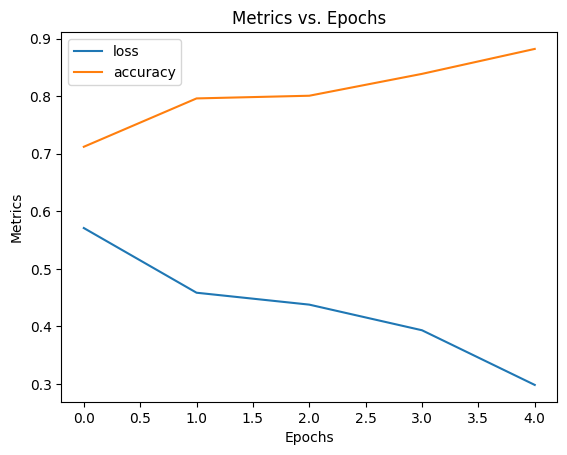

In [15]:
utils.plot.plot_history(history_1)

### Feed Forward Neural Network Model (For Comparison)

In [16]:
# Setting random seed for comparison
tf.random.set_seed(42)

# 1. Create Model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# 2. Compile Model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

# 3. Fit Model
model_2.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data))

Epoch 1/5
 1/47 [..............................] - ETA: 15s - loss: 0.7270 - accuracy: 0.4375

2023-07-21 14:28:26.048031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 225.6755 - accuracy: 0.4987

2023-07-21 14:28:28.959149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 4s 83ms/step - loss: 225.6755 - accuracy: 0.4987 - val_loss: 247.0876 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 4s 77ms/step - loss: 197.9789 - accuracy: 0.5000 - val_loss: 149.4622 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 4s 77ms/step - loss: 102.5084 - accuracy: 0.5000 - val_loss: 56.1639 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 4s 78ms/step - loss: 18.7483 - accuracy: 0.5280 - val_loss: 2.0624 - val_accuracy: 0.6320
Epoch 5/5
47/47 [==============================] - 4s 78ms/step - loss: 1.9325 - accuracy: 0.6133 - val_loss: 1.8824 - val_accuracy: 0.6040


In [17]:
# Looking at some details of model_2
# There are ~602,000 trainable parameters here (20X more parameters than model 1).
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602141 (2.30 MB)
Trainable params: 602141 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# See if we can make a better feed forward model
# Setting random seed for comparison
tf.random.set_seed(42)

# 1. Create Model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# 2. Compile Model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

# 3. Fit Model
model_3.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data))

Epoch 1/5


2023-07-21 14:28:44.896427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 20.1446 - accuracy: 0.6240

2023-07-21 14:28:48.275618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 5s 90ms/step - loss: 20.1446 - accuracy: 0.6240 - val_loss: 17.3331 - val_accuracy: 0.5680
Epoch 2/5
47/47 [==============================] - 4s 87ms/step - loss: 11.2814 - accuracy: 0.6447 - val_loss: 9.2879 - val_accuracy: 0.6640
Epoch 3/5
47/47 [==============================] - 4s 87ms/step - loss: 4.7535 - accuracy: 0.7340 - val_loss: 4.3611 - val_accuracy: 0.6760
Epoch 4/5
47/47 [==============================] - 4s 87ms/step - loss: 7.8048 - accuracy: 0.6347 - val_loss: 4.1953 - val_accuracy: 0.6980
Epoch 5/5
47/47 [==============================] - 4s 87ms/step - loss: 4.8141 - accuracy: 0.6907 - val_loss: 13.6060 - val_accuracy: 0.5100


In [19]:
# Looking at model 3 structure
# ~15 million trainable parameters (500X number of trainable parameters compared to the CNN)
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15073201 (57.50 MB)
Trainable params: 15073201 (57.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Re-looking at Convolutional Neural Network Steps

Now that I have done a simple example of a CNN, and compared it against the feed forward neural network, I am going to take a step back and analyze the actual steps that goes into building out a CNN.

## Binary Classification (Breaking it Down)

1. Become one with the data
2. Preprocess the data (scaled/normalized)
3. Created model (started with a simple baseline)
4. Fit the Model
5. Evaluate the Model
6. Adjust and improve the Model (Beat the baseline)
7. Repeat until optimal/satisfied

## 0. Gathering the Dataset

In [20]:
# Image dataset location
data_directory = pathlib.Path('./data/food-101/pizza_steak')
test_directory = data_directory / 'test'
train_directory = data_directory / 'train'

## 1. Analyzing the Dataset

Steak - Image Shape: (384, 512, 3)
Pizza - Image Shape: (384, 512, 3)


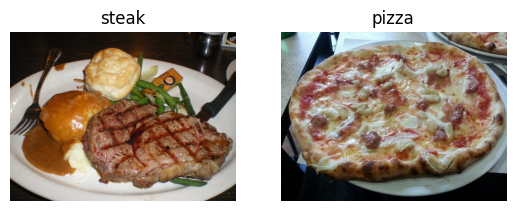

In [21]:
# Visualize the data
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image(target_dir=str(train_directory), target_class=class_names[1])
plt.subplot(1, 2, 2)
pizza_img = view_random_image(target_dir=str(train_directory), target_class=class_names[0])

## 2. Preprocessing Data

Preparing data for the model (split data, normalize data, batch data, etc.).

### 2.1 Batch Data

The next step is to turn out data into **batches**. A batch is a small subset of data. Rather than look at all ~10,000 images at one time, a model might only look at 32 at a time. It does this for a couple of reasons:

1. 10,000 images (or more) might not fit into the memory of the processor.
2. Trying to learn the patterns in 10,000 images in one hit could result in a poorly learned model.

**NOTE** A batch size of 32 is a commonly used batch size for neural networks, and has been tested and found that it is a good batch size for many scenarios.

In [22]:
# Creating train and test data generators
train_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_data = train_data_gen.flow_from_directory(
    directory=str(train_directory),
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary',
    seed=42)

test_data = valid_data_gen.flow_from_directory(
    directory=str(test_directory),
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary',
    seed=42)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [23]:
# Get a sample of a train data batch
images, labels = train_data.next()
len(images), len(labels)

(32, 32)

In [24]:
# Looking at the shape of each image, and verify that it has been normalized
images[0].shape, images[0].max(), images[0].min()

((224, 224, 3), 1.0, 0.0)

## 3. Create, Compile, Fit & Evaluate Model

Starting with a Baseline model. A Baseline mode is a relatively simple model or existing result that you setup when beginning a machine learning experiment, and is used as a baseline when trying to improve your model.

In [25]:
# Make the Model Creation simpler
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

### Baseline Model

In [26]:
# Setting the random seed
tf.random.set_seed(42)

# 1. Create Model
baseline_model = Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           strides=1,
           padding='valid',
           activation='relu',
           input_shape=(224, 224, 3),
           name='InputLayer'),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid', name='OutputLayer')
])

# 2. Compile Model
baseline_model.compile(loss='binary_crossentropy',
                       optimizer=Adam(),
                       metrics=['accuracy'])

# 3. Fit Model
# NOTE: train_data is a combination of X and y, so don't need to send both
# NOTE: We don't have a validation dataset, so going to use the test set
baseline_history = baseline_model.fit(train_data,
                                      epochs=5,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=len(test_data))

Epoch 1/5


2023-07-21 14:29:06.440027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.5356 - accuracy: 0.7400

2023-07-21 14:29:09.561069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 4s 83ms/step - loss: 0.5356 - accuracy: 0.7400 - val_loss: 0.4209 - val_accuracy: 0.8200
Epoch 2/5
47/47 [==============================] - 4s 81ms/step - loss: 0.3932 - accuracy: 0.8293 - val_loss: 0.4747 - val_accuracy: 0.7700
Epoch 3/5
47/47 [==============================] - 4s 81ms/step - loss: 0.2749 - accuracy: 0.8953 - val_loss: 0.4039 - val_accuracy: 0.8400
Epoch 4/5
47/47 [==============================] - 4s 81ms/step - loss: 0.1263 - accuracy: 0.9607 - val_loss: 0.3656 - val_accuracy: 0.8500
Epoch 5/5
47/47 [==============================] - 4s 81ms/step - loss: 0.0286 - accuracy: 0.9973 - val_loss: 0.5844 - val_accuracy: 0.7940


In [27]:
baseline_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (Conv2D)         (None, 222, 222, 10)      280       
                                                                 
 conv2d_4 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_5 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 OutputLayer (Dense)         (None, 1)                 475241    
                                                                 
Total params: 477341 (1.82 MB)
Trainable params: 477341 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


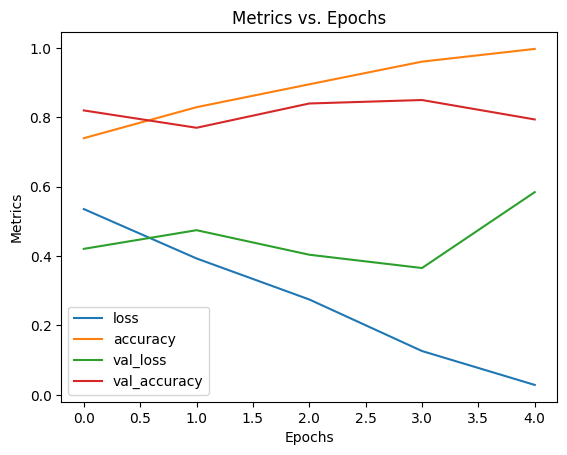

In [28]:
utils.plot.plot_history(baseline_history)

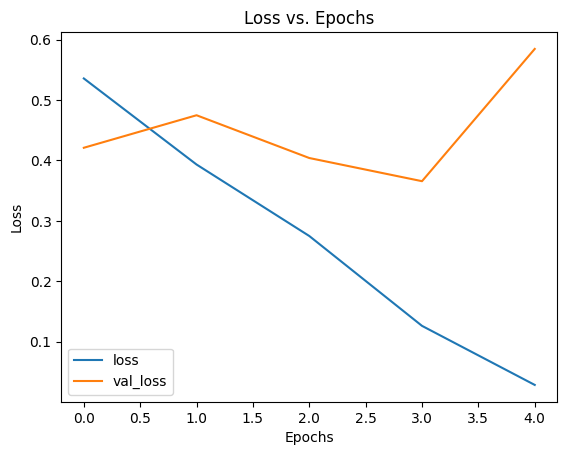

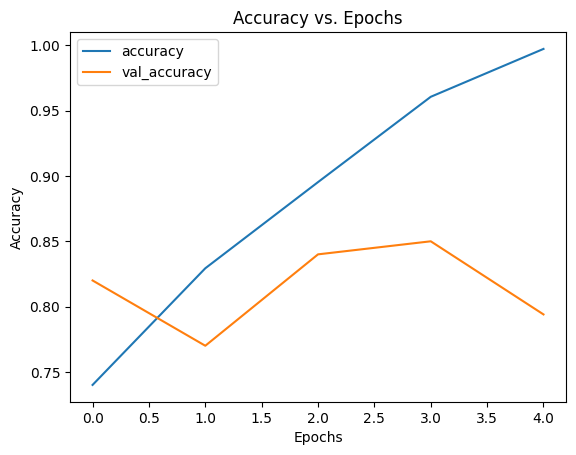

In [29]:
utils.plot.plot_history(baseline_history, metric='loss')
utils.plot.plot_history(baseline_history, metric='accuracy')

#### Findings

When a models's validation loss starts to increase, it's likely that the model is overfitting the training dataset This means it's learning the patterns in the training set too well and thus the model's ability to generalize unseen data will be diminished.

### Model-1: Adust Model to Combat Overfitting

Fitting a machine learning model comes in 3 steps:

0. Create a baseline model to compare models against.
1. Beat the baseline by overfitting a larger model.
2. Reduce overfitting,

Ways to induce overfitting:

1. Increase the number of conv layers.
2. Increase the number of conv filters.
3. Add another dense layer to the output of our flattened layer.


Reduce overfitting:

1. Add data augmentation.
2. Add regularization (MaxPool2D).
3. Add more data

In [30]:
# Setting the random seed
tf.random.set_seed(42)

# 1. Create Model
model_1 = Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           strides=1,
           padding='valid',
           activation='relu',
           input_shape=(224, 224, 3),
           name='InputLayer'),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid', name='OutputLayer')
])

# 2. Compile Model
model_1.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# 3. Fit Model
# NOTE: train_data is a combination of X and y, so don't need to send both
# NOTE: We don't have a validation dataset, so going to use the test set
model_1_history = model_1.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=len(test_data))

Epoch 1/5


2023-07-21 14:29:26.544726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.5847 - accuracy: 0.6820

2023-07-21 14:29:29.593241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 4s 83ms/step - loss: 0.5847 - accuracy: 0.6820 - val_loss: 0.4360 - val_accuracy: 0.7880
Epoch 2/5
47/47 [==============================] - 4s 81ms/step - loss: 0.4406 - accuracy: 0.7960 - val_loss: 0.3641 - val_accuracy: 0.8620
Epoch 3/5
47/47 [==============================] - 4s 81ms/step - loss: 0.3996 - accuracy: 0.8253 - val_loss: 0.3309 - val_accuracy: 0.8700
Epoch 4/5
47/47 [==============================] - 4s 81ms/step - loss: 0.3934 - accuracy: 0.8367 - val_loss: 0.3228 - val_accuracy: 0.8720
Epoch 5/5
47/47 [==============================] - 4s 79ms/step - loss: 0.3636 - accuracy: 0.8387 - val_loss: 0.3612 - val_accuracy: 0.8360


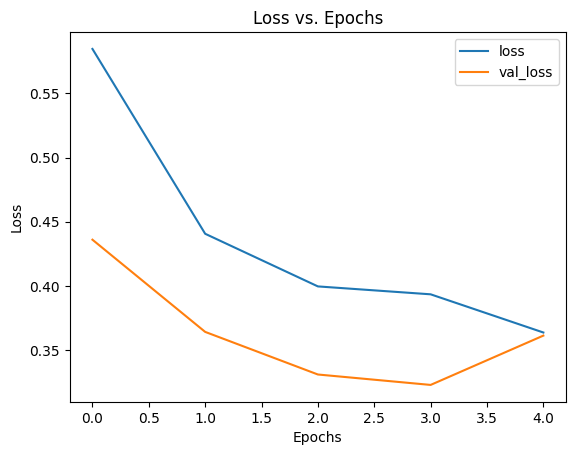

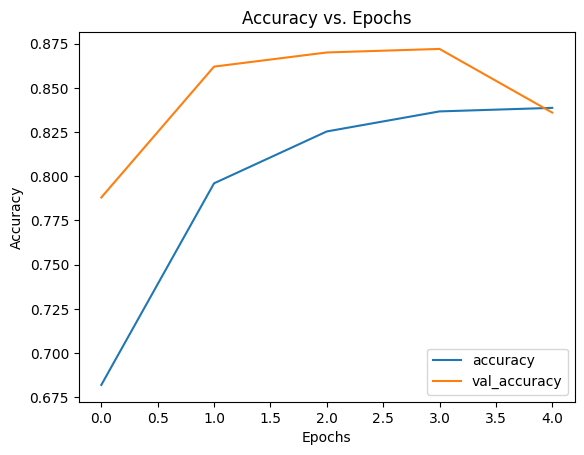

In [31]:
utils.plot.plot_history(model_1_history, metric='loss')
utils.plot.plot_history(model_1_history, metric='accuracy')

In [32]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (Conv2D)         (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 26, 26, 10)       

#### Findings

After implementing pooling into the CNN, the training data set and the validation (testing in our case) data set followed a similar trajectory. This is what we want to see in our models which limits overfitting.

NOTE: Reducing overfitting is also know as regularization.

## Model-2: Adjust Overfitting using Data Augmentation

Data augmentation is the process of altering our training data, leading it to have more diversity and in turn allowing ormodels to learn more generalizable (hopefully) patterns. Alterming might mean adjusting the rotation of an image, flipping it, cropping it, etc.

**NOTE** Data augmentation is usually only performed on the training data.

### Resetting Up the ImageDataGenerator & Image Datasets

In [33]:
# Create ImageDataGenerator training instance with Data Augmentation
train_data_gen_augmented = ImageDataGenerator(rescale=1./255,
                                             rotation_range=0.2,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.3,
                                             horizontal_flip=True)

# Create ImageDataGenerator training instance without DataAugmentation
train_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

# Creating the datasets for training and test sets
train_data_augmented = train_data_gen_augmented.flow_from_directory(
    directory=str(train_directory),
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary',
    shuffle=False)

train_data = train_data_gen.flow_from_directory(
    directory=str(train_directory),
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary',
    shuffle=False)

test_data = test_data_gen.flow_from_directory(
    directory=str(test_directory),
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary')

Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


### Visualizing the Augmented Data

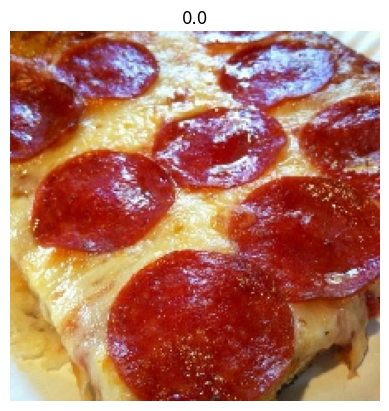

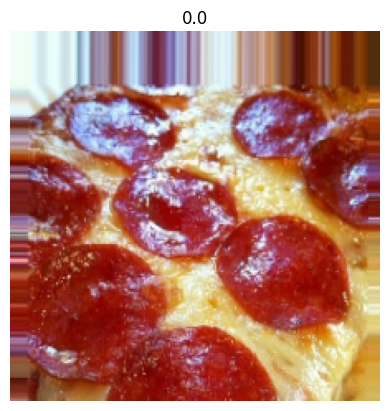

In [34]:
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next()

random_index = random.randint(0, len(images)-1)

view_image_from_batch(images, labels, random_index)
view_image_from_batch(augmented_images, augmented_labels, random_index)

In [35]:
# Setting the random seed
tf.random.set_seed(42)

# 1. Create Model
model_2 = Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           strides=1,
           padding='valid',
           activation='relu',
           input_shape=(224, 224, 3),
           name='InputLayer'),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid', name='OutputLayer')
])

# 2. Compile Model
model_2.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# 3. Fit Model
# NOTE: train_data is a combination of X and y, so don't need to send both
# NOTE: We don't have a validation dataset, so going to use the test set
model_2_history = model_2.fit(train_data_augmented,
                              epochs=5,
                              steps_per_epoch=len(train_data_augmented),
                              validation_data=test_data,
                              validation_steps=len(test_data))

Epoch 1/5


2023-07-21 14:29:47.102440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.6994 - accuracy: 0.4280

2023-07-21 14:29:57.057888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 11s 233ms/step - loss: 0.6994 - accuracy: 0.4280 - val_loss: 0.6894 - val_accuracy: 0.5560
Epoch 2/5
47/47 [==============================] - 11s 233ms/step - loss: 0.6932 - accuracy: 0.5087 - val_loss: 0.6821 - val_accuracy: 0.7280
Epoch 3/5
47/47 [==============================] - 11s 236ms/step - loss: 0.6848 - accuracy: 0.6353 - val_loss: 0.6732 - val_accuracy: 0.5260
Epoch 4/5
47/47 [==============================] - 11s 233ms/step - loss: 0.6810 - accuracy: 0.5900 - val_loss: 0.5915 - val_accuracy: 0.7660
Epoch 5/5
47/47 [==============================] - 11s 234ms/step - loss: 0.6684 - accuracy: 0.6933 - val_loss: 0.5167 - val_accuracy: 0.8020


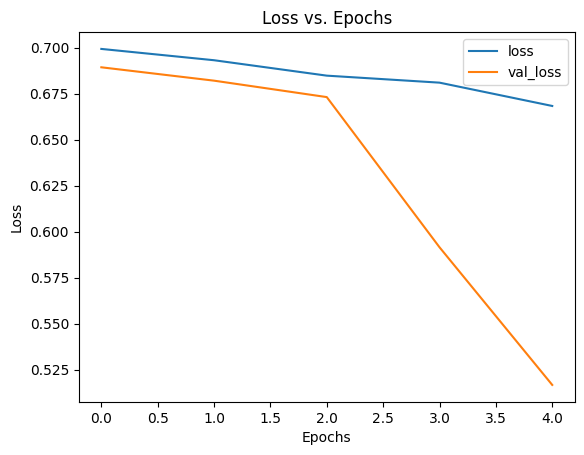

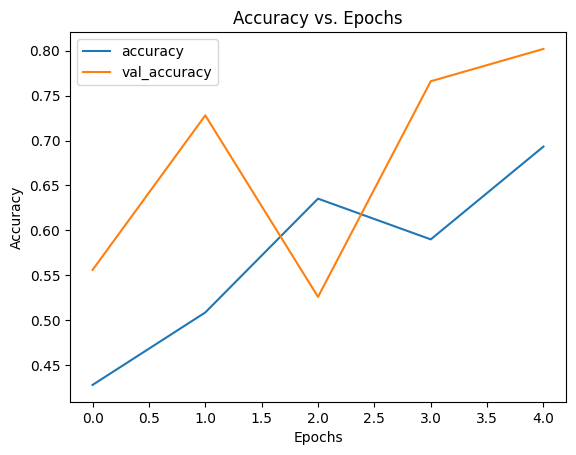

In [36]:
utils.plot.plot_history(model_2_history, metric='loss')
utils.plot.plot_history(model_2_history, metric='accuracy')

## Model-3: Augmentation w/ Shuffled Data

In model 2, I didn't shuffle the data so I could see exactly what the augmentation does against data. Going to do the same thing as model-2, but turn on shuffle.

In [37]:
# Create ImageDataGenerator training instance with Data Augmentation
train_data_gen_augmented = ImageDataGenerator(rescale=1./255,
                                             rotation_range=0.2,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.3,
                                             horizontal_flip=True)

# Create ImageDataGenerator training instance without DataAugmentation
test_data_gen = ImageDataGenerator(rescale=1./255)

# Creating the datasets for training and test sets
train_data_augmented = train_data_gen_augmented.flow_from_directory(
    directory=str(train_directory),
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary',
    shuffle=True)

test_data = test_data_gen.flow_from_directory(
    directory=str(test_directory),
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary')

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [38]:
# Setting the random seed
tf.random.set_seed(42)

# 1. Create Model
model_3 = Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           strides=1,
           padding='valid',
           activation='relu',
           input_shape=(224, 224, 3),
           name='InputLayer'),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid', name='OutputLayer')
])

# 2. Compile Model
model_3.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# 3. Fit Model
# NOTE: train_data is a combination of X and y, so don't need to send both
# NOTE: We don't have a validation dataset, so going to use the test set
model_3_history = model_3.fit(train_data_augmented,
                              epochs=5,
                              steps_per_epoch=len(train_data_augmented),
                              validation_data=test_data,
                              validation_steps=len(test_data))

Epoch 1/5


2023-07-21 14:30:42.964691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.6520 - accuracy: 0.6093

2023-07-21 14:30:53.291937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 12s 240ms/step - loss: 0.6520 - accuracy: 0.6093 - val_loss: 0.5021 - val_accuracy: 0.7580
Epoch 2/5
47/47 [==============================] - 11s 235ms/step - loss: 0.5680 - accuracy: 0.6987 - val_loss: 0.4390 - val_accuracy: 0.8100
Epoch 3/5
47/47 [==============================] - 11s 240ms/step - loss: 0.5263 - accuracy: 0.7433 - val_loss: 0.3847 - val_accuracy: 0.8440
Epoch 4/5
47/47 [==============================] - 11s 237ms/step - loss: 0.4987 - accuracy: 0.7593 - val_loss: 0.4686 - val_accuracy: 0.7560
Epoch 5/5
47/47 [==============================] - 11s 235ms/step - loss: 0.4863 - accuracy: 0.7773 - val_loss: 0.3717 - val_accuracy: 0.8360


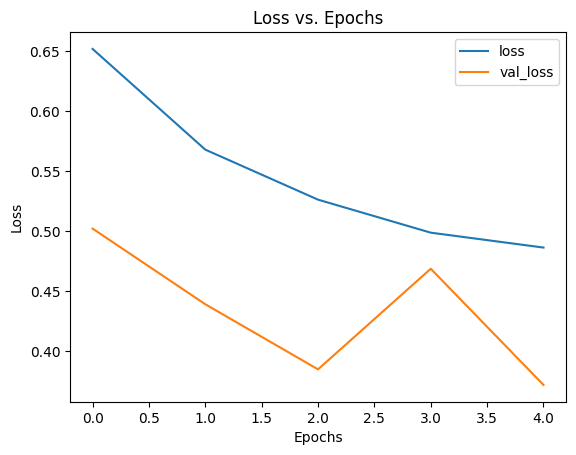

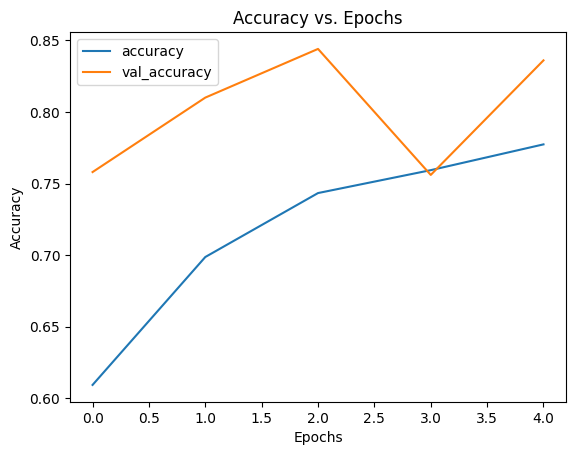

In [39]:
utils.plot.plot_history(model_3_history, metric='loss')
utils.plot.plot_history(model_3_history, metric='accuracy')

### Findings

Just turning on shuffling for the training data sifnificantly increased accuracy from model 2.

## Model 4: Improve Accuracy by Increase Filters in Each Layer

Since we've already beaten our baseline, there are a few things to try to improve the model:

1. Increate number of model layers.
2. Increate filters in each layer.
3. Train for longer..
4. Find ideal learning rate.
5. More data!
6. Use transfer learning.

In [40]:
# Setting the random seed
tf.random.set_seed(42)

# 1. Create Model
model_4 = Sequential([
    Conv2D(filters=20,
           kernel_size=3,
           strides=1,
           padding='valid',
           activation='relu',
           input_shape=(224, 224, 3),
           name='InputLayer'),
    MaxPool2D(pool_size=2),
    Conv2D(20, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(20, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid', name='OutputLayer')
])

# 2. Compile Model
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# 3. Fit Model
# NOTE: train_data is a combination of X and y, so don't need to send both
# NOTE: We don't have a validation dataset, so going to use the test set
model_4_history = model_4.fit(train_data_augmented,
                              epochs=5,
                              steps_per_epoch=len(train_data_augmented),
                              validation_data=test_data,
                              validation_steps=len(test_data))

Epoch 1/5


2023-07-21 14:31:39.643613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.6362 - accuracy: 0.6267

2023-07-21 14:31:50.095554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 12s 237ms/step - loss: 0.6362 - accuracy: 0.6267 - val_loss: 0.4261 - val_accuracy: 0.8200
Epoch 2/5
47/47 [==============================] - 11s 241ms/step - loss: 0.5310 - accuracy: 0.7507 - val_loss: 0.4110 - val_accuracy: 0.8300
Epoch 3/5
47/47 [==============================] - 11s 242ms/step - loss: 0.4914 - accuracy: 0.7673 - val_loss: 0.3612 - val_accuracy: 0.8640
Epoch 4/5
47/47 [==============================] - 11s 243ms/step - loss: 0.4917 - accuracy: 0.7747 - val_loss: 0.3961 - val_accuracy: 0.8160
Epoch 5/5
47/47 [==============================] - 11s 241ms/step - loss: 0.5005 - accuracy: 0.7680 - val_loss: 0.3351 - val_accuracy: 0.8720


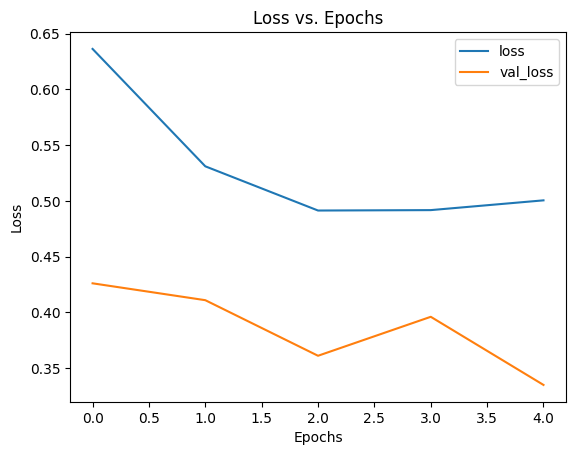

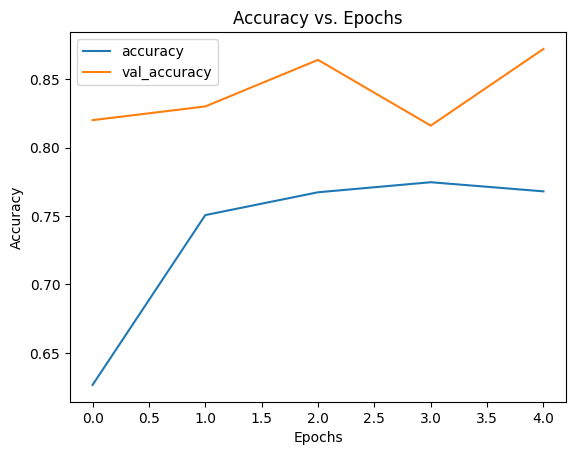

In [41]:
utils.plot.plot_history(model_4_history, metric='loss')
utils.plot.plot_history(model_4_history, metric='accuracy')

## Model 5: Increase Accuracy by Training for Longer

In [42]:
# Setting the random seed
tf.random.set_seed(42)

# 1. Create Model
model_5 = Sequential([
    Conv2D(filters=20,
           kernel_size=3,
           strides=1,
           padding='valid',
           activation='relu',
           input_shape=(224, 224, 3),
           name='InputLayer'),
    MaxPool2D(pool_size=2),
    Conv2D(20, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(20, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid', name='OutputLayer')
])

# 2. Compile Model
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# 3. Fit Model
# NOTE: train_data is a combination of X and y, so don't need to send both
# NOTE: We don't have a validation dataset, so going to use the test set
model_5_history = model_5.fit(train_data_augmented,
                              epochs=10,
                              steps_per_epoch=len(train_data_augmented),
                              validation_data=test_data,
                              validation_steps=len(test_data))

Epoch 1/10


2023-07-21 14:32:37.393893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.6667 - accuracy: 0.5687

2023-07-21 14:32:47.624634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 11s 237ms/step - loss: 0.6667 - accuracy: 0.5687 - val_loss: 0.6187 - val_accuracy: 0.6080
Epoch 2/10
47/47 [==============================] - 11s 235ms/step - loss: 0.5723 - accuracy: 0.7113 - val_loss: 0.3846 - val_accuracy: 0.8280
Epoch 3/10
47/47 [==============================] - 11s 235ms/step - loss: 0.5116 - accuracy: 0.7453 - val_loss: 0.3871 - val_accuracy: 0.8340
Epoch 4/10
47/47 [==============================] - 11s 234ms/step - loss: 0.5157 - accuracy: 0.7553 - val_loss: 0.4518 - val_accuracy: 0.7800
Epoch 5/10
47/47 [==============================] - 11s 235ms/step - loss: 0.4919 - accuracy: 0.7620 - val_loss: 0.3695 - val_accuracy: 0.8440
Epoch 6/10
47/47 [==============================] - 11s 232ms/step - loss: 0.4864 - accuracy: 0.7600 - val_loss: 0.3660 - val_accuracy: 0.8320
Epoch 7/10
47/47 [==============================] - 11s 232ms/step - loss: 0.4873 - accuracy: 0.7647 - val_loss: 0.3399 - val_accuracy: 0.8620
Epoch 8/10

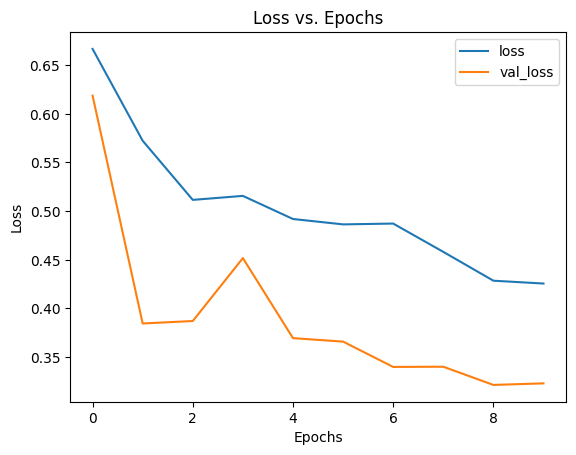

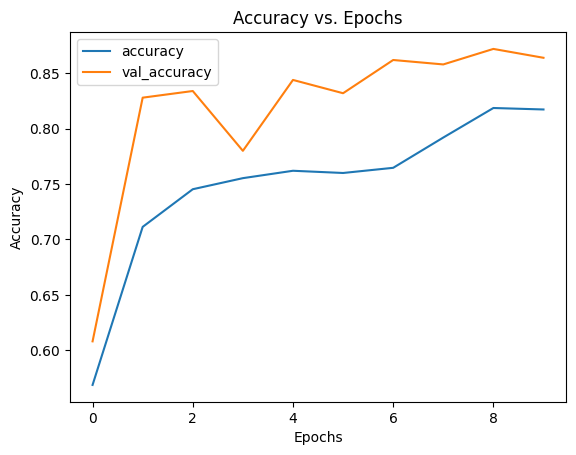

In [43]:
utils.plot.plot_history(model_5_history, metric='loss')
utils.plot.plot_history(model_5_history, metric='accuracy')

In [44]:
# Test Image location
test_image_directory = pathlib.Path('./data/food-101/model_testing')
steak_filename = test_image_directory / 'steak' / 'steak-and-eggs-2-2.jpeg'
steak_filename

PosixPath('data/food-101/model_testing/steak/steak-and-eggs-2-2.jpeg')

(-0.5, 1199.5, 1598.5, -0.5)

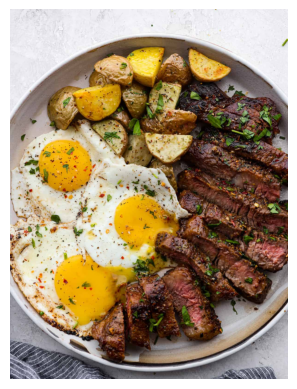

In [45]:
steak = mpimg.imread(steak_filename)
plt.imshow(steak)
plt.axis(False)

In [46]:
steak.shape

(1599, 1200, 3)

#### NOTE

When you train a neural network and you want to make a preduction with it on you own custom data, 

1/1 [==============================] - 0s 69ms/step


2023-07-21 14:34:28.576750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


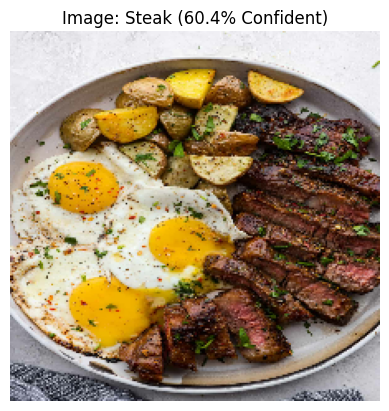

In [47]:
get_predicted_class(model_4, str(steak_filename), class_names)

In [48]:
class_names

array(['pizza', 'steak'], dtype='<U5')

# Multi-class Image Classification

We've just been through a bunch of the steps below with binary classification. Now I am going to perform the following steps with a multi-class classification problem.

1. Become one with the data
2. Prepreocess the data.
3. Create a model (start with baseline).
4. Fit the model (overfit it to make sure it works).
5. Evaluate the model
6. Adjust hyperparameters to improve the model and reduce overfitting.
7. Repeat until satisfied.

## Imports

In [49]:
import os
import pathlib
import random
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from src import utils

## Download & Analyze Dataset

The dataset used is the Food 101 dataset commonly used to to explore Computer Vision. For simplicity of getting started with Computer Vision, I am only going to be looking at two image classes to work quickly with a smaller dataset before applying learnings to the larger dataset.

* https://www.kaggle.com/datasets/dansbecker/food-101 (original kaggle page of dataset)
* https://github.com/mrdbourke/tensorflow-deep-learning/ (getting the modified dataset)

In [50]:
# Image dataset location
data_directory = pathlib.Path('./data/food-101/10_food_classes_all_data')
test_directory = data_directory / 'test'
train_directory = data_directory / 'train'

## 1. Visualizing the Data

In [51]:
summarize_image_directory(data_directory)

Directory: data/food-101/10_food_classes_all_data/test/ice_cream Total Images: 250
Directory: data/food-101/10_food_classes_all_data/test/chicken_curry Total Images: 250
Directory: data/food-101/10_food_classes_all_data/test/steak Total Images: 250
Directory: data/food-101/10_food_classes_all_data/test/sushi Total Images: 250
Directory: data/food-101/10_food_classes_all_data/test/chicken_wings Total Images: 250
Directory: data/food-101/10_food_classes_all_data/test/grilled_salmon Total Images: 250
Directory: data/food-101/10_food_classes_all_data/test/hamburger Total Images: 250
Directory: data/food-101/10_food_classes_all_data/test/pizza Total Images: 250
Directory: data/food-101/10_food_classes_all_data/test/ramen Total Images: 250
Directory: data/food-101/10_food_classes_all_data/test/fried_rice Total Images: 250
Directory: data/food-101/10_food_classes_all_data/train/ice_cream Total Images: 750
Directory: data/food-101/10_food_classes_all_data/train/chicken_curry Total Images: 750


In [52]:
# Let's get the subdirectories
class_names = get_classnames_from_directory(train_directory)
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

Ice_cream - Image Shape: (512, 307, 3)


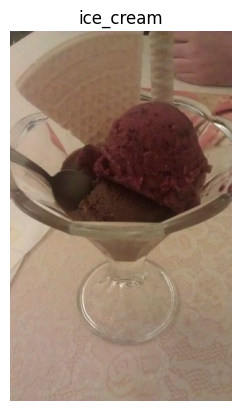

In [53]:
# Lets look at some images
img = view_random_image(target_dir=train_directory, target_class=random.choice(class_names))

## 2. Preprocessing the Data

In [54]:
# Scaling values
scale = 1. / 255
img_size = 224
batch_size = 32

# Creating data generator
train_data_gen = ImageDataGenerator(rescale=scale)
test_data_gen = ImageDataGenerator(rescale=scale)

# Loading data in batches
train_data = train_data_gen.flow_from_directory(str(train_directory),
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size,
                                                class_mode='categorical')

test_data = test_data_gen.flow_from_directory(str(test_directory),
                                              target_size=(img_size, img_size),
                                              batch_size=batch_size,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## 3. Create the Baseline Model

We've been takling a lot wabout the CNN explainer website. They've been using 10 classes as well, so lets start out with creating our baseline model using the same architecture they use.

* https://poloclub.github.io/cnn-explainer/

In [58]:
# Set seed
tf.random.set_seed(42)

# 1. Create Model (same as in CNN explainer)
baseline_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           strides=1,
                           padding='valid',
                           activation='relu',
                           input_shape=(img_size, img_size, 3),
                           name='InputLayer'),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax', name='OutputLayer')
    
])

# 2. Compile Model
baseline_model.compile(loss='categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])

# 3. Fit Model
baseline_history = baseline_model.fit(train_data,
                                      epochs=5,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=len(test_data))

Epoch 1/5


2023-07-21 14:36:24.086833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 2.1567 - accuracy: 0.2017

2023-07-21 14:36:40.808226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 22s 92ms/step - loss: 2.1567 - accuracy: 0.2017 - val_loss: 2.0630 - val_accuracy: 0.2636
Epoch 2/5
235/235 [==============================] - 21s 89ms/step - loss: 1.8720 - accuracy: 0.3564 - val_loss: 1.8679 - val_accuracy: 0.3372
Epoch 3/5
235/235 [==============================] - 22s 93ms/step - loss: 1.4807 - accuracy: 0.5031 - val_loss: 2.0199 - val_accuracy: 0.3332
Epoch 4/5
235/235 [==============================] - 22s 93ms/step - loss: 0.9938 - accuracy: 0.6692 - val_loss: 2.4795 - val_accuracy: 0.2952
Epoch 5/5
235/235 [==============================] - 22s 92ms/step - loss: 0.5025 - accuracy: 0.8388 - val_loss: 3.4615 - val_accuracy: 0.2812


In [59]:
baseline_model.evaluate(test_data)

79/79 [==============================] - 5s 59ms/step - loss: 3.4615 - accuracy: 0.2812


[3.461459159851074, 0.28120002150535583]

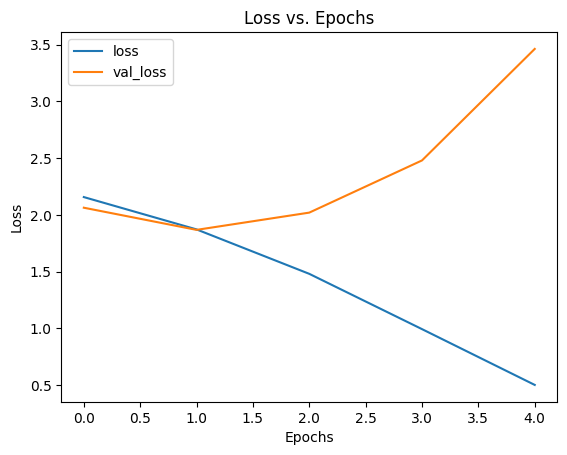

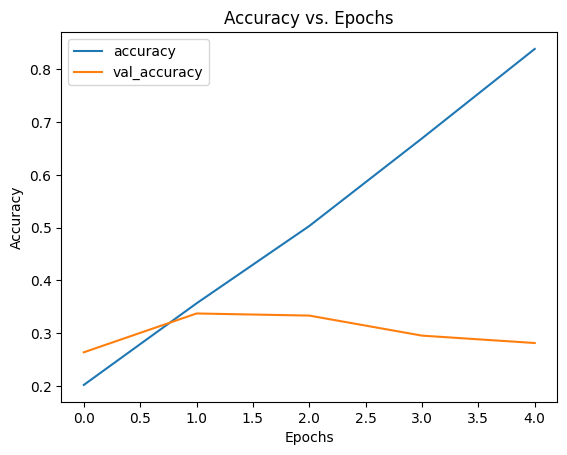

In [60]:
utils.plot.plot_history(baseline_history, metric='loss')
utils.plot.plot_history(baseline_history, metric='accuracy')

### Findings

From the loss curves, it the validation loss starts to increase when the training loss decreases, indicating that the model is overfitting. Next steps to adjust overfitting is to introduce data augmentation, regularization, etc.

Ways of adjusting the model for overfitting:

1. Get more data. This allows for more opportunity to learn diverse patterns.
2. Simplify the model. Remove layers, filters, etc.
3. Data Augmentation. Data augmentation manipulates the training data in such a way to add more diversity to it without altering the original data.
4. Transfer Learning: Transf er learning leverages the patterens another model has similar data that has been fitted for, and we can use those patterns on our model.

## Model-1: Adjust for Overfitting by Simplifying Model (Removing Layers)

Cutting out the two Conv2D layers before the MaxPool

In [61]:
# Set seed
tf.random.set_seed(42)

# 1. Create Model (same as in CNN explainer)
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           strides=1,
                           padding='valid',
                           activation='relu',
                           input_shape=(img_size, img_size, 3),
                           name='InputLayer'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax', name='OutputLayer')
    
])

# 2. Compile Model
model_1.compile(loss='categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])

# 3. Fit Model
model_1_history = model_1.fit(train_data,
                                      epochs=5,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=len(test_data))

Epoch 1/5


2023-07-21 14:38:17.369541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 2.2334 - accuracy: 0.1936

2023-07-21 14:38:33.952630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 22s 92ms/step - loss: 2.2334 - accuracy: 0.1936 - val_loss: 2.0538 - val_accuracy: 0.2736
Epoch 2/5
235/235 [==============================] - 22s 92ms/step - loss: 1.9028 - accuracy: 0.3444 - val_loss: 1.9972 - val_accuracy: 0.2860
Epoch 3/5
235/235 [==============================] - 22s 94ms/step - loss: 1.5284 - accuracy: 0.4925 - val_loss: 2.0310 - val_accuracy: 0.2968
Epoch 4/5
235/235 [==============================] - 22s 94ms/step - loss: 1.0485 - accuracy: 0.6691 - val_loss: 2.2771 - val_accuracy: 0.2912
Epoch 5/5
235/235 [==============================] - 22s 93ms/step - loss: 0.6194 - accuracy: 0.8175 - val_loss: 2.6850 - val_accuracy: 0.2800


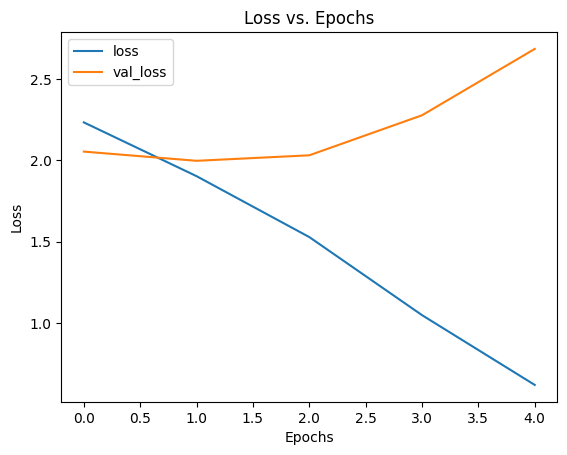

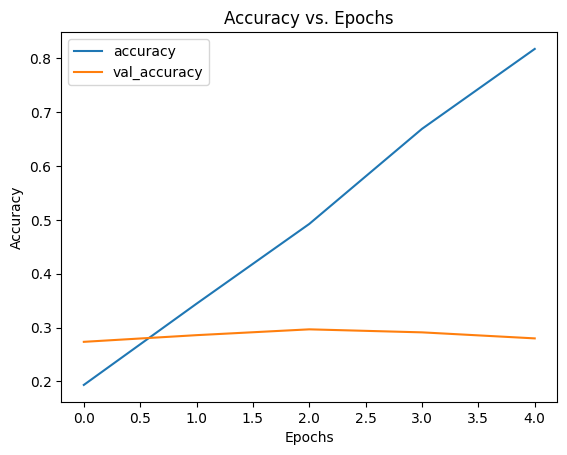

In [62]:
utils.plot.plot_history(model_1_history, metric='loss')
utils.plot.plot_history(model_1_history, metric='accuracy')

In [63]:
model_1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (Conv2D)         (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 111, 111, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 54, 54, 10)        0         
 ng2D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 29160)             0         
                                                                 
 OutputLayer (Dense)         (None, 10)              

#### Findings

From the loss curves, the accuracy went down and overfitting remained. Next step is to adjust the overfitting of the baseline model with data augmentation.

## Model-2: Addressing Overfitting Using Data Augmentation

Trying to reduce overitting with data augmentation. Ideally, we want to:
* Reduce overfitting
* Increase validation accuracy

##### Step-0: Loading, Preprocessing, and Augmenting Data

In [64]:
# Scaling values
scale = 1. / 255
img_size = 224
batch_size = 32

# Creating data generator
train_data_augmented_gen = ImageDataGenerator(rescale=scale,
                                    rotation_range=0.2,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=scale)

# Loading data in batches
train_data = train_data_augmented_gen.flow_from_directory(str(train_directory),
                                                          target_size=(img_size, img_size),
                                                          batch_size=batch_size,
                                                          class_mode='categorical')

test_data = test_data_gen.flow_from_directory(str(test_directory),
                                              target_size=(img_size, img_size),
                                              batch_size=batch_size,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [65]:
# Set seed
tf.random.set_seed(42)

# 1. Create Model (using clone model for quick)
model_2 = tf.keras.models.clone_model(baseline_model)

# 2. Compile Model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 3. Fit Model
model_2_history = model_2.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=len(test_data))

Epoch 1/5


2023-07-21 14:40:13.379887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 2.1986 - accuracy: 0.1880

2023-07-21 14:41:05.610814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 58s 244ms/step - loss: 2.1986 - accuracy: 0.1880 - val_loss: 2.0644 - val_accuracy: 0.2408
Epoch 2/5
235/235 [==============================] - 57s 242ms/step - loss: 2.0980 - accuracy: 0.2533 - val_loss: 1.9625 - val_accuracy: 0.3120
Epoch 3/5
235/235 [==============================] - 55s 235ms/step - loss: 2.0336 - accuracy: 0.2787 - val_loss: 1.9560 - val_accuracy: 0.3204
Epoch 4/5
235/235 [==============================] - 55s 235ms/step - loss: 1.9828 - accuracy: 0.3041 - val_loss: 1.8819 - val_accuracy: 0.3560
Epoch 5/5
235/235 [==============================] - 56s 239ms/step - loss: 1.9467 - accuracy: 0.3249 - val_loss: 1.8876 - val_accuracy: 0.3612


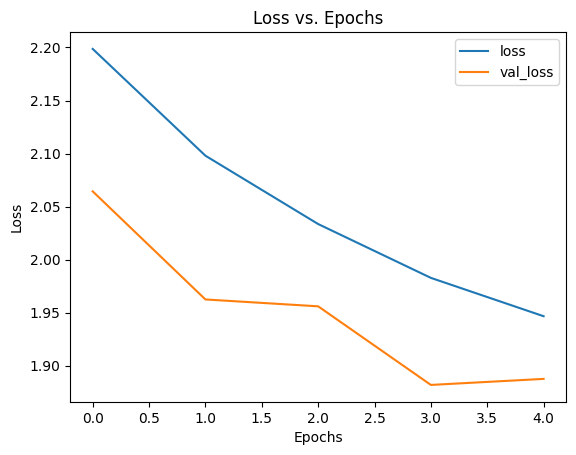

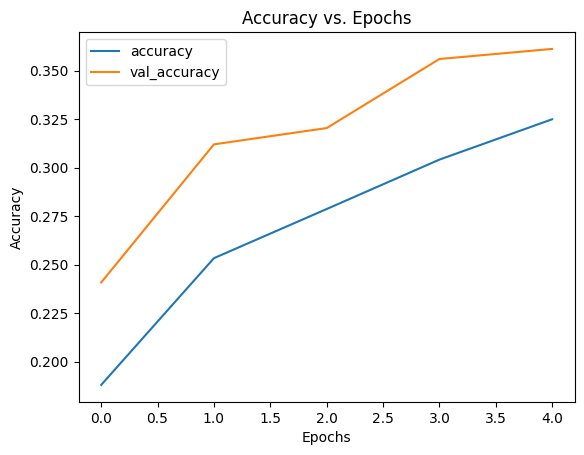

In [68]:
utils.plot.plot_history(model_2_history, metric='loss')
utils.plot.plot_history(model_2_history, metric='accuracy')

#### Findings:

The loss curve looks significantly better! The loss curves resemble each other much better, and are still increasing after epoch 5, so more epochs would likely result in a better accuracy. How else can we experiment to improve this accuracy?

* Adjust model architecture
* Adjust augmentation hyper parameters.
* Train for longer
* Adjust learning rate.
* Try Transfer Learning

### Lets Test our Model w/ New Custom Images

In [69]:
# Test Image location
test_image_directory = pathlib.Path('./data/food-101/model_testing')
steak_filename = test_image_directory / 'steak' / 'steak-and-eggs-2-2.jpeg'
steak_filename

PosixPath('data/food-101/model_testing/steak/steak-and-eggs-2-2.jpeg')

(-0.5, 1199.5, 1598.5, -0.5)

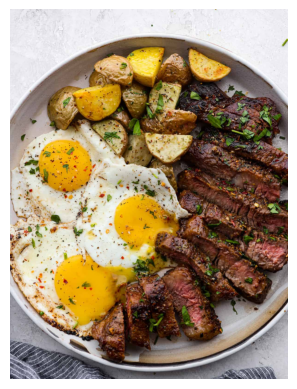

In [70]:
steak = mpimg.imread(steak_filename)
plt.imshow(steak)
plt.axis(False)

1/1 [==============================] - 0s 13ms/step


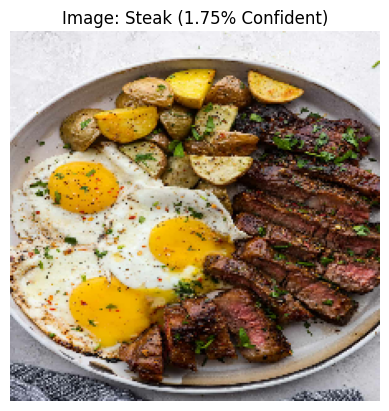

In [74]:
get_predicted_class(model_2, str(steak_filename), class_names)

## Save & Load Model

In [75]:
model_2.save('saved_trained_model_2')

INFO:tensorflow:Assets written to: saved_trained_model_2/assets


INFO:tensorflow:Assets written to: saved_trained_model_2/assets


In [76]:
# Verify that the model saved and loads correctly
loaded_model_2 = tf.keras.models.load_model('saved_trained_model_2')
loaded_model_2.evaluate(test_data)

 1/79 [..............................] - ETA: 13s - loss: 1.8715 - accuracy: 0.3125

2023-07-21 14:59:19.128282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 5s 67ms/step - loss: 1.8876 - accuracy: 0.3612


[1.8876022100448608, 0.3612000048160553]

In [77]:
model_2.evaluate(test_data)

79/79 [==============================] - 5s 66ms/step - loss: 1.8876 - accuracy: 0.3612


[1.8876028060913086, 0.3612000048160553]